# Modelo para Detecção de Fraudes em Cartões de Crédito

Neste projeto, iremos abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. Apenas no Brasil, cerca de 12,1 milhões de pessoas já foram vítimas de algum tipo de fraude financeira no último ano. Traduzindo em valores, os golpes financeiros ultrapassaram a cifra de R$ 1,8 bilhão de prejuízo por ano para os últimos 12 meses.

<p align=center>
<img src="https://www.sismotel.com.br/wp-content/uploads/2020/04/fraude-de-cartao-de-credito.jpeg" width="50%"></p>

Dentre essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acarretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*.

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de Reais. E esse é o desafio desse projeto, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

# **1 - Importando os Dados**

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$

<p align=center>
<img src="https://media.licdn.com/dms/image/D4D12AQHD-FpZInpW4w/article-cover_image-shrink_720_1280/0/1659888015873?e=2147483647&v=beta&t=fb1T8l0kMDWCdcO-KN_gxQ3YaJRyGn6h-2s2Gsbz4nc" width="50%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor ou igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

## 1.1 - Importar Bibliotecas

In [1]:
# Manipulação e visualização dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-Processamento dos dados
from sklearn.preprocessing import RobustScaler
from scipy.stats import norm

# Validação e divisão dos modelos
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

# Criação dos modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Balanceamento dos dados
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Bibliotecas Complementares
from scipy import interp
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.pipeline import Pipeline
import time
import warnings
from collections import Counter
import os
import pickle

# Bibliotecas de métricas para avaliar nosso modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'matplotlib'

Para facilitar a aquisição dos dados, criei um *link* com acesso direto ao `csv`. Com isso, basta importar o conjunto de dados usando o método `pd.read_csv()`.

## 1.2 - Criar o DataFrame

In [ ]:
# Importar os dados para um dataframe
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"
df = pd.read_csv(file_path)

# Arredondar as colunas V1 a V28 do dataframe para facilitar a visualização
df.loc[:, 'V1':'V28'] = df.loc[:, 'V1':'V28'].round(2)

Com os dados importados para dentro de uma estrutura *Dataframe* - e não havendo a necessidade de mais nenhum ajuste ou configuração nesta etapa, pode-se iniciar uma análise exploratória dos dados a fim de preparar um modelo de *Machine Learning*.

# 2 - Análise Exploratória
Iremos procurar entender um pouco mais sobre os dados, encontrar padrões para uma tomada de decisão mais precisa e a análise exploratória nos permite isso.


## 2.1 - Descrição dos dados

In [ ]:
# Verificar as primeiras entradas
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.0,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.0,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.0,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.0,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


Podemos confirmar o que foi dito no começo sobre as colunas estarem agrupadas em componetes devido ao uso do PCA nos dados.

In [ ]:
# Verificar o resumo estatístico dos dados
df[['Time', 'Amount','Class']].describe().round(2)

,Time,Amount,Class
count,284807.00,284807.00,284807.00
mean,94813.86,88.35,0.00
std,47488.15,250.12,0.04
min,0.00,0.00,0.00
25%,54201.50,5.60,0.00
50%,84692.00,22.00,0.00
75%,139320.50,77.16,0.00
max,172792.00,25691.16,1.00


Podemos ver na descrição acima que a média de trançasões está em 88,35(vamos assumir que a unidade monetária seja genérica pois não foi apresentado em que moeda esta) e o desvio padrão em 250,12 o que é consideravelmente alto e nisso podemos ver que a maioria das transações variam abaixo da média, já que os 3 quartis(25%, 50% e 75%) estão abaixo da média, o que significa que como temos um desvio padrão alto então temos algumas transações muito altas e iremos nos aprofundar um pouco mais nisso.

In [ ]:
# Verificar se existe valores ausentes
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Iremos fazer um gráfico de barra para tentar explicar se as colunas PCA tem alguma que se destaque mais que as outras.

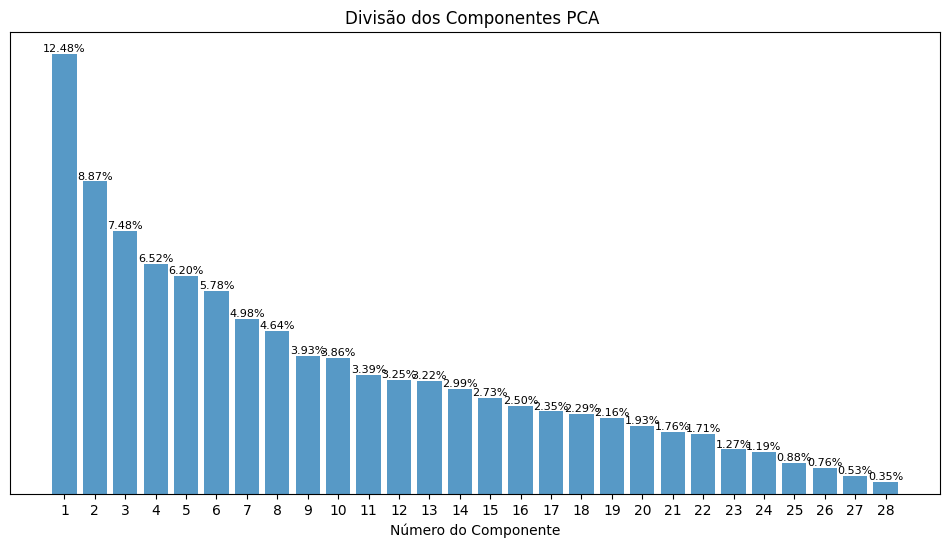

In [ ]:
# Calcular a matriz de covariância dos componentes do PCA
pca_components = df.loc[:, 'V1':'V28']
covariance_matrix = pca_components.cov()

# Calcular a proporção da variância explicada por cada componente, dividindo as variâncias dos componentes pela variância total
explained_variance_ratio = covariance_matrix.values.diagonal() / covariance_matrix.values.sum() * 100

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.75)
plt.xlabel('Número do Componente')
plt.title('Divisão dos Componentes PCA ')
plt.xticks(range(1, len(explained_variance_ratio) + 1))

# Adicionar as porcentagens acima das barras
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{explained_variance_ratio[i]:.2f}%', ha='center', va='bottom', fontsize=8)

# Remover as linhas de grade
plt.grid(False)

# Remover o eixo y
plt.yticks([])

plt.show()

No gráfico acima podemos ver que não há um componente que se destaque significativamente dos demais.

Isso nos indica que, para esses dados específicos, não há uma característica muito dominante que possa explicar a maioria das variâncias. Em vez disso, é necessário considerar vários componentes juntos para ter uma explicação mais completa dos dados.

A Seguir iremos criar um outro gráfico para entender se podemos desconsiderar os componentes com uma variância menor e tentar usar somente os componentes com uma alta variância.

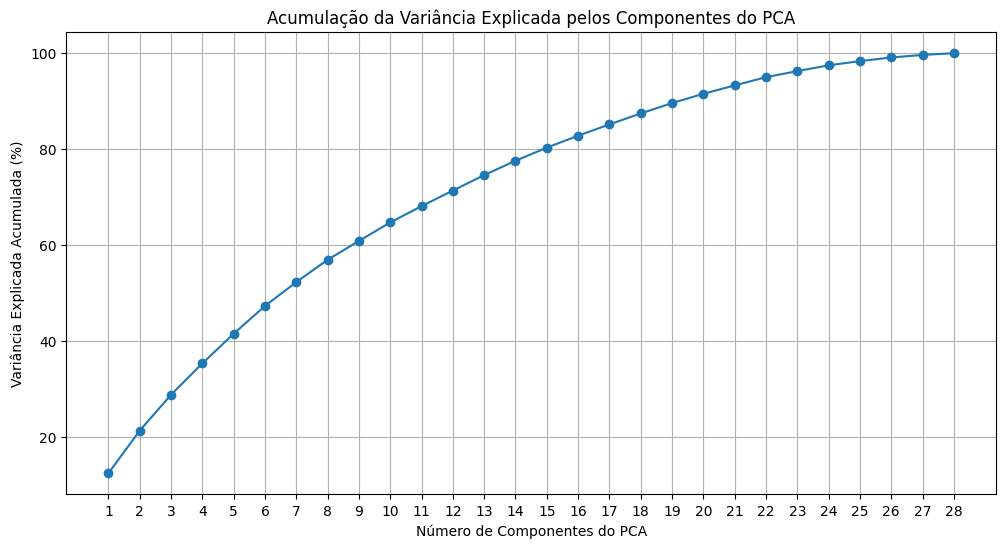

In [ ]:
# Calcular a acumulação da variância explicada
explained_variance_cumulative = np.cumsum(explained_variance_ratio) * 100

# Criar o gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(explained_variance_cumulative) + 1), explained_variance_cumulative, marker='o', linestyle='-')
plt.xlabel('Número de Componentes do PCA')
plt.ylabel('Variância Explicada Acumulada (%)')
plt.title('Acumulação da Variância Explicada pelos Componentes do PCA')
plt.xticks(range(1, len(explained_variance_cumulative) + 1))
plt.grid(True)

plt.show()

No grafico acima podemos observar que, mesmo que um componente individual tenha uma variação menor, ele pode contribuir significativamente para a variação acumulada, quando considerado em conjunto com os demais componentes do PCA. É nesse contexto de combinação de componentes que a importância relativa de cada um é determinada.

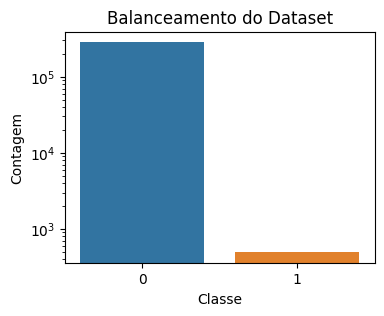

In [ ]:
# Criar o countplot com o balanceamento dos dados
plt.figure(figsize=(4, 3))
sns.countplot(x='Class', data=df)
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.title('Balanceamento do Dataset')

# Adicionar escala logarítmica ao eixo y
plt.yscale('log')

plt.show()

Acima podemos verificar como os dados estamos totalmente desbalanceados e para facilitar a visualização coloquei os dados na escala logaritmica no qual amplia a visualização dos dados menores devido a sua forma de contagem que não é linear e sim exponencial.

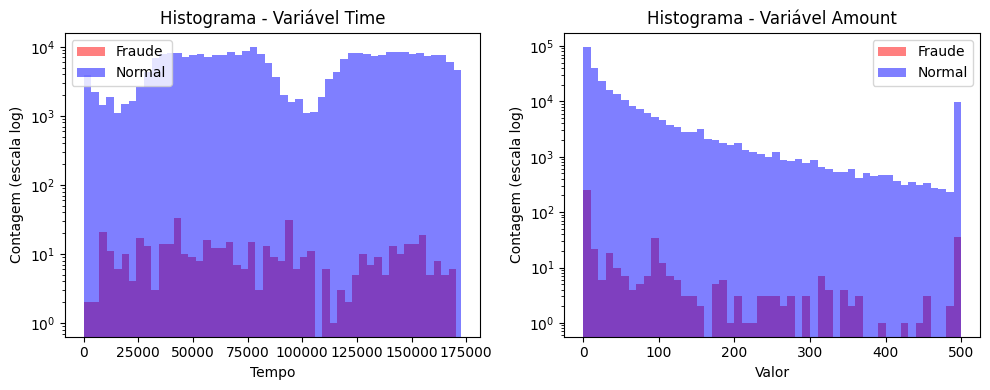

In [ ]:
# Filtrar os dados para as transações de fraude
fraud_data = df[df['Class'] == 1]

# Filtrar os dados para as transações normais
normal_data = df[df['Class'] == 0]

# Limitar os valores da variável 'Amount' entre 0 e 500
fraud_amount_clipped = np.clip(fraud_data['Amount'], 0, 500)
normal_amount_clipped = np.clip(normal_data['Amount'], 0, 500)

# Criar o subplot com 1 linha e 2 colunas
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Histograma - Variável Time
axs[0].hist(fraud_data['Time'], bins=50, alpha=0.5, color='red', label='Fraude')
axs[0].hist(normal_data['Time'], bins=50, alpha=0.5, color='blue', label='Normal')
axs[0].set_xlabel('Tempo')
axs[0].set_ylabel('Contagem (escala log)')
axs[0].set_title('Histograma - Variável Time')
axs[0].legend()
axs[0].set_yscale('log')

# Histograma - Variável Amount
axs[1].hist(fraud_amount_clipped, bins=50, alpha=0.5, color='red', label='Fraude')
axs[1].hist(normal_amount_clipped, bins=50, alpha=0.5, color='blue', label='Normal')
axs[1].set_xlabel('Valor')
axs[1].set_ylabel('Contagem (escala log)')
axs[1].set_title('Histograma - Variável Amount')
axs[1].legend()
axs[1].set_yscale('log')

# Ajustar o espaçamento entre os subplots
plt.tight_layout()

# Exibir o subplot
plt.show()

No histograma de quantidade vemos que os maiores valores vão até 300 reais depois começam a diminuir isso nos ajuda a entender que um fraudador costuma efetuar a fraude com valores até 300 reais.

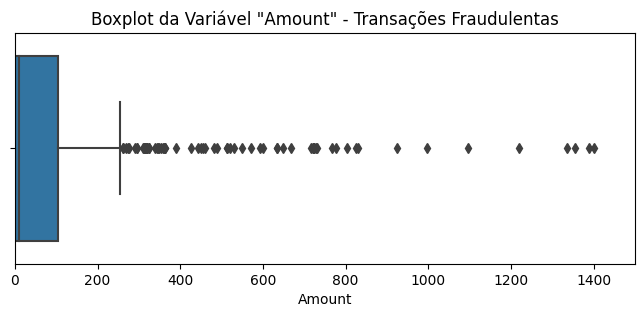

In [ ]:
# Filtrar os dados com fraude
fraud_data = df[df['Class'] == 1]

# Definir o limite superior para a variável Amount
amount_limit = 1500

# Filtrar os dados com valores de Amount até o limite definido
fraud_data_filtered = fraud_data[fraud_data['Amount'] <= amount_limit]

# Plotar o boxplot da variável Amount para os dados de fraude
plt.figure(figsize=(8, 3))
sns.boxplot(x='Amount', data=fraud_data_filtered, orient='h')
plt.xlim(0, amount_limit)
plt.xlabel('Amount')
plt.title('Boxplot da Variável "Amount" - Transações Fraudulentas')

plt.show()

Podemos visualizar no boxplot acima que temos alguns valores discrepantes e vamos tratar eles para que nosso modelo performe melhor.

# 3 - Pré-Processamento dos dados

## 3.1 - Escalonamento de dados
Iremos agora fazer um escalonamento dos dados no qual é uma técnica de pré-processamento usada para colocar os dados na mesma escala para ajudar o nosso modelo a entender melhor os dados.

Iremos usar o RobustScaler que é uma técnica de pré-processamento que consiste em escalonar os dados tornando-os mais robustos a outliers e a variações extremas.

Ele é particularmente útil quando os seus dados contêm valores discrepantes (outliers) que podem afetar negativamente o desempenho de algoritmos sensíveis a escala.

Ao contrário de outras técnicas de escalonamento, como a padronização (z-score), o RobustScaler não depende da média e do desvio padrão para dimensionar os dados. Em vez disso, ele utiliza medidas de posição e dispersão mais robustas a outliers, como a mediana e a amplitude interquartil (IQR).

In [ ]:
# Criar uma instância do RobustScaler
rob_scaler = RobustScaler()

# Normalizar os dados das colunas "Time" e "Amount"
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [ ]:
# Organizar o dataset colocadno time e amount no inicio.
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']


df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,...,0.25,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,0
1,-0.269825,-0.994983,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,...,-0.07,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,0
2,4.983721,-0.994972,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,...,0.52,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,0
3,1.418291,-0.994972,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,...,-0.21,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,0
4,0.670579,-0.994960,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,...,0.41,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,0


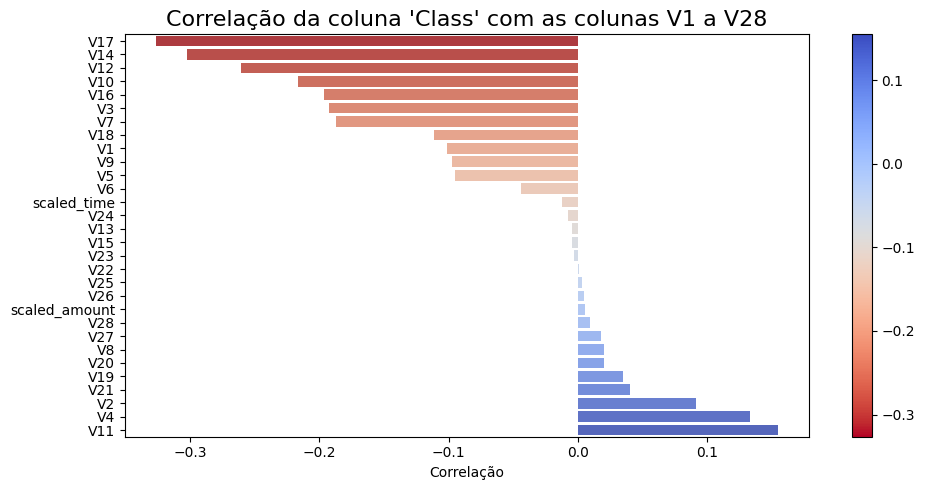

In [ ]:
# Calcule a correlação entre 'Class' e as colunas 'V1' a 'V28'
correlations = df.corr()['Class'].drop('Class')

# Ordene as correlações em ordem crescente
sorted_correlations = correlations.sort_values()

# Plote o gráfico de barras com cores variadas
plt.figure(figsize=(10, 5))
sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette='coolwarm_r')
plt.title("Correlação da coluna 'Class' com as colunas V1 a V28", fontsize=16)
plt.xlabel('Correlação')

# Modificar o tom do azul e vermelho com base nos valores da correlação
norm = plt.Normalize(sorted_correlations.min(), sorted_correlations.max())
sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=norm)
cbar = plt.colorbar(sm)

plt.tight_layout()

plt.show()

Podemos ver nas correlações que temos alguns componentes que tem mais correlação do que outros com a nossa variável preditiva e iremos verificar o quão influente essas colunas são em relação a nossa classe.

As colunas que usaremos serão as:

**Positivas:** V11, V4, V2, V19

**Negativas:** V14, V12, V10, V16

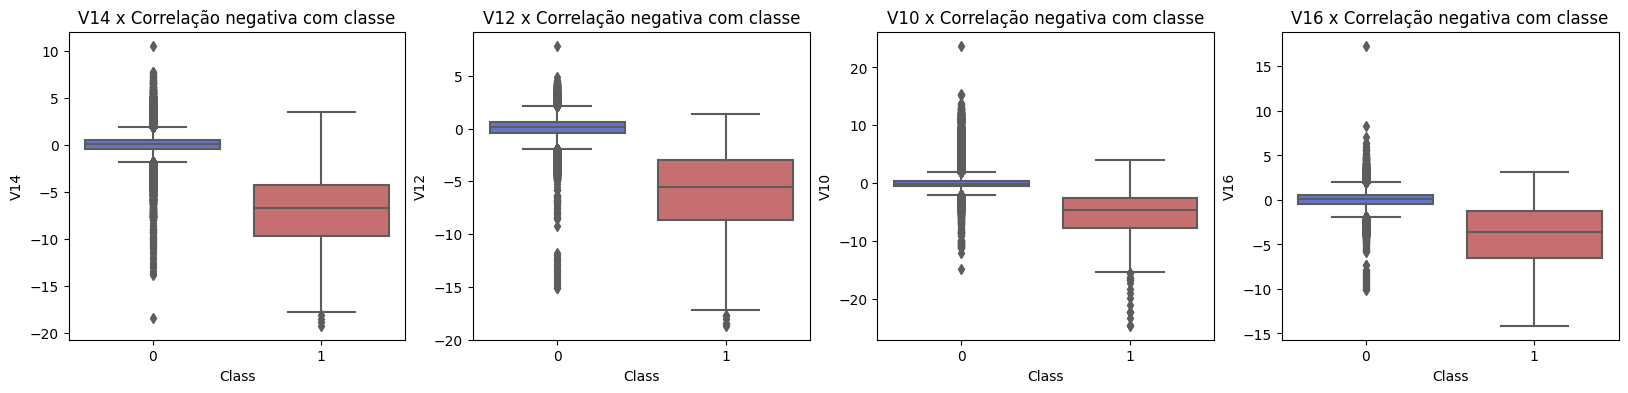

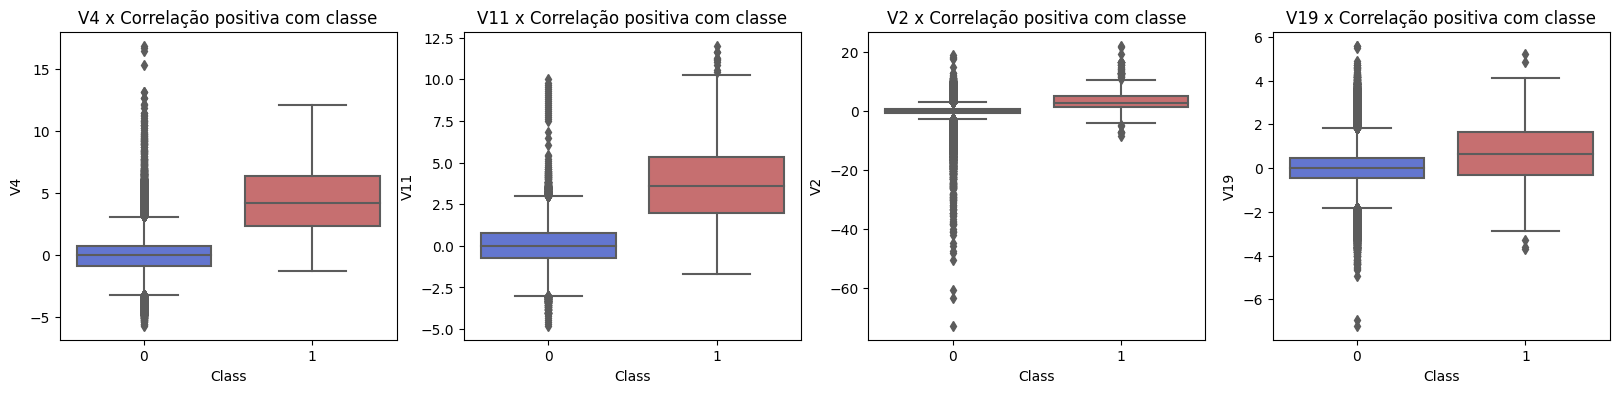

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors = ['#516BE1', '#D56062']

# Correlações negativa com a nossa classe
sns.boxplot(x="Class", y="V14", data=df, palette=colors, ax=axes[0])
axes[0].set_title('V14 x Correlação negativa com classe')

sns.boxplot(x="Class", y="V12", data=df, palette=colors, ax=axes[1])
axes[1].set_title('V12 x Correlação negativa com classe')

sns.boxplot(x="Class", y="V10", data=df, palette=colors, ax=axes[2])
axes[2].set_title('V10 x Correlação negativa com classe')

sns.boxplot(x="Class", y="V16", data=df, palette=colors, ax=axes[3])
axes[3].set_title('V16 x Correlação negativa com classe')

f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Correlações positivas com a nossa classe
sns.boxplot(x="Class", y="V4", data=df, palette=colors, ax=axes[0])
axes[0].set_title('V4 x Correlação positiva com classe')

sns.boxplot(x="Class", y="V11", data=df, palette=colors, ax=axes[1])
axes[1].set_title('V11 x Correlação positiva com classe')

sns.boxplot(x="Class", y="V2", data=df, palette=colors, ax=axes[2])
axes[2].set_title('V2 x Correlação positiva com classe')

sns.boxplot(x="Class", y="V19", data=df, palette=colors, ax=axes[3])
axes[3].set_title('V19 x Correlação positiva com classe')

plt.tight_layout
plt.show()

Podemos ver nos boxplots acima que quando temos um PCA com correlação positiva maior é a probabilidade de termos uma transação fraudulenta, e da mesma forma quando temos um PCA com correlação negativa maior é a probabilidade de termos uma transação negativa.

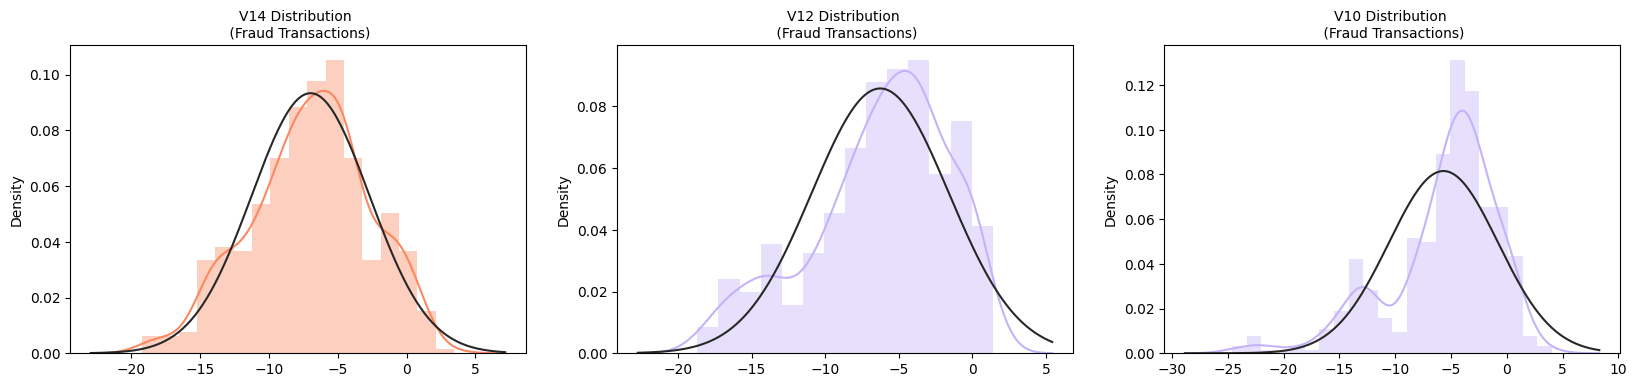

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 4))

v14_fraud_dist = df['V14'].loc[df['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=10)

v12_fraud_dist = df['V12'].loc[df['Class'] == 1].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color='#C5B3F9')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=10)

v10_fraud_dist = df['V10'].loc[df['Class'] == 1].values
sns.distplot(v10_fraud_dist, ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=10)

plt.show()

Podemos ver que na tres distribuições somente a V14 esta com os dados normalizados.

## 3.2 - Remoção de Outliers

In [ ]:
# Função para remover outliers de uma coluna específica
def remove_outliers(df, column_name):
    fraud_values = df[column_name].loc[df['Class'] == 1].values

    # Calcula os quartis 25 e 75 para os valores de fraude
    q25, q75 = np.percentile(fraud_values, 25), np.percentile(fraud_values, 75)

    # Calcula a amplitude interquartil (IQR)
    iqr = q75 - q25

    # Calcula os limites superior e inferior para identificar outliers
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # Identifica os outliers na coluna
    outliers = [x for x in fraud_values if x < lower or x > upper]

    # Exibe informações sobre os outliers encontrados
    print(f'{column_name} Lower: {lower}')
    print(f'{column_name} Upper: {upper}')
    print(f'{column_name} outliers: {outliers}')
    print(f'Feature {column_name} Outliers for Fraud Cases: {len(outliers)}')

    # Remove as linhas com outliers da coluna
    df = df.drop(df[(df[column_name] > upper) | (df[column_name] < lower)].index)
    print('Número de instâncias após a remoção dos outliers:', len(df))
    print('----' * 44)

    return df

# Lista das colunas a serem processadas
columns_to_process = ['V14', 'V12', 'V10']

# Itera sobre as colunas e aplica a função de remoção de outliers
for column in columns_to_process:
    df = remove_outliers(df, column)

V14 Lower: -17.810000000000002
V14 Upper: 3.83
V14 outliers: [-19.21, -18.82, -18.49, -18.05]
Feature V14 Outliers for Fraud Cases: 4
Número de instâncias após a remoção dos outliers: 284510
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.342499999999998
V12 Upper: 5.777499999999998
V12 outliers: [-18.05, -18.68, -18.55, -18.43]
Feature V12 Outliers for Fraud Cases: 4
Número de instâncias após a remoção dos outliers: 284506
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.88375
V10 Upper: 4.90625
V10 outliers: [-15.12, -16.65, -18.27, -15.24, -15.24, -14.92, -14.92, -15.56, -15.56, -16.75, -15.35, -15.12, -22.19, -22.19, -22.19, -22.19, -17.14, -16.3, -16.26, -16.6, -15.23, -18.91, -20.95, -19.84, -23.23

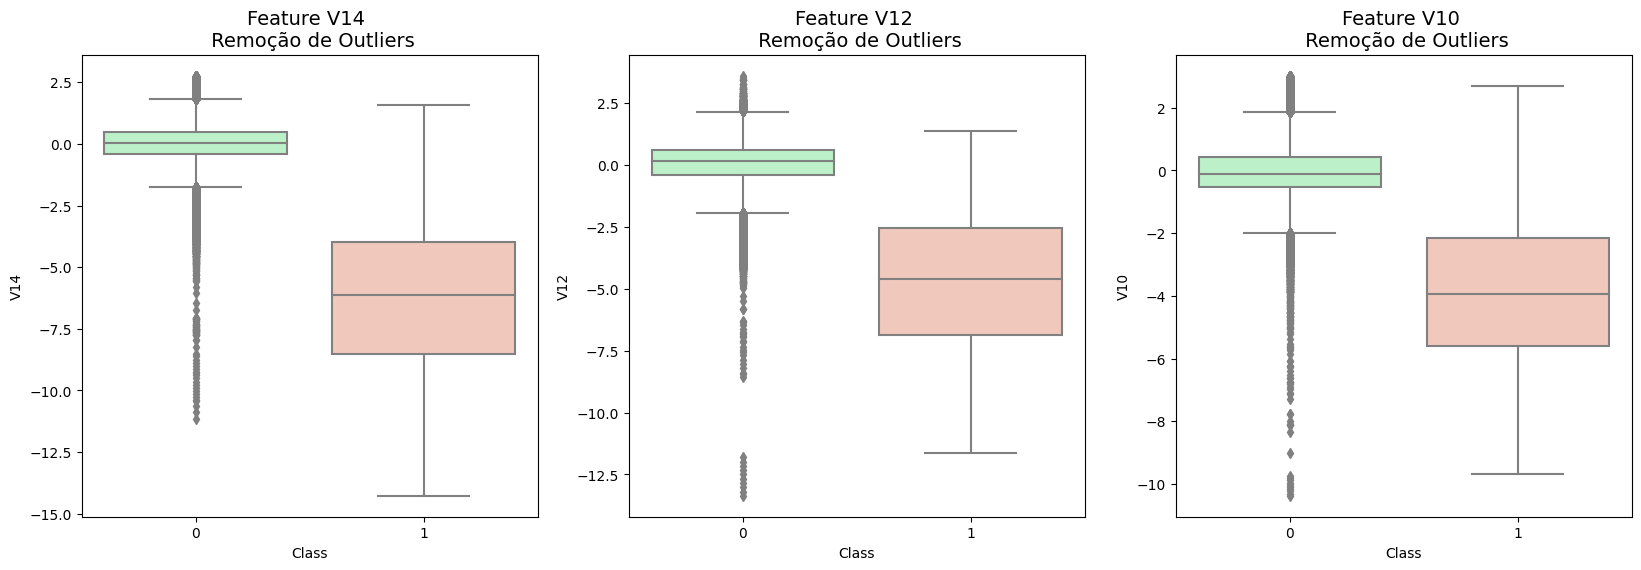

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
colors = ['#B3F9C5', '#f9c5b3']

# Boxplots com outliers removidos
for i, column in enumerate(['V14', 'V12', 'V10']):
    ax = [ax1, ax2, ax3][i]

    # Boxplot
    sns.boxplot(x="Class", y=column, data=df, ax=ax, palette=colors)
    ax.set_title(f"Feature {column} \n Remoção de Outliers", fontsize=14)

plt.show()

Podemos verificar acima como nossa variável class ficou depois da remoção dos outliers

# 4 - Machine Learning
A partir de agora iremos criar alguns modelos de machine learning para fazer nossas predições.

## 4.1 - Preparação dos dados
Como boa prática, devemos separar os dados antes de qualquer transformação no conjunto de dados, vamos seguir da seguinte forma:

**Separaremos o dataset em treino e teste**, sendo que o teste vamos dividir com 20% de todo o conjunto e **não mexeremos nele até o modelo escolhido estar devidamente ajustado e validado.**

**Os dados de treino**, por sua vez, vamos separar **em treino e validação** para assim otimizar os parâmetros do modelo.

Embora testamos e otimizamos os modelos, não temos como prever se o modelo irá performar bem em produção, por isso, o acompanhamento inicial é fundamental para certificar que o modelo realmente funciona, ou ainda precisa de ajustes.

In [ ]:
# Separando os dados para treino e teste
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# Visualizando as proporções de treino da variável alvo
df_train.Class.value_counts(normalize=True)

0    0.998326
1    0.001674
Name: Class, dtype: float64

In [ ]:
# Visualizando as proporções de teste da variável alvo
df_test.Class.value_counts(normalize=True)

0    0.998557
1    0.001443
Name: Class, dtype: float64

Os dois conjuntos estão com a mesma proporção na variável resposta. **A partir de agora vamos trabalhar somente com o conjunto de dados de treino e o teste iremos utiliza-lo somente para validação final do nosso modelo.**

Então vamos separar o conjunto de dados de treino, em treino e validação.

## 4.2 - Definindo a baseline

A baseline é o resultado que vamos querer "bater", para ver o quanto conseguiremos melhorar nosso modelo, após devidamente treinado e quanto maior o resultado em relação à baseline melhor, **tomando cuidado com os riscos de overfitting.**

Começamos dividindo o conjunto de dados em treino e validação e após separar o X (variáveis preditoras) e y (variável target), utilizaremos o **StratifiedKFold que separa os dados para uma validação cruzada preservando o percentual de amostras em cada classe.**

Faremos um loop e assim conseguiremos ter os nossos dados separados, conforme mencionado.

In [ ]:
# Dividindo X e y
X = df_train.drop('Class', axis=1)
y = df_train.Class

# Separando os dados mantendo a porcentagem de amostras em cada classe
StratifKfold = StratifiedKFold(n_splits=5)

# Looping para separar os dados em treino e validação
for train_index, val_index in StratifKfold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

print(f'Dimensões: {X_train.shape, X_val.shape, y_train.shape, y_val.shape}\n')

Dimensões: ((181124, 30), (45280, 30), (181124,), (45280,))



Agora vamos treinar um modelo simples (sem parâmetros) de Regressão Logística. A Regressão Logística na maioria dos casos performa bem e foi escolhido para definição da baseline.

Treinaremos o modelo, faremos as predições tanto nos dados de treino quanto de validação e calcularemos as métricas de Accuracy, Precision, Recall e F1-Score.

In [ ]:
# instanciando o modelo
logReg = LogisticRegression()

# treinando o modelo
logReg.fit(X_train, y_train)

# prevendo nos dados de treino
y_pred_base_train = logReg.predict(X_train)

# prevendo nos dados de validação
y_pred_base_val = logReg.predict(X_val)

print('Nos dados de TREINO:')

print('---' * 20)
print('Modelo:    Regressão Logística (Baseline)\n')
print(f"accuracy:  {accuracy_score(y_train, y_pred_base_train)}")
print(f"precision: {precision_score(y_train, y_pred_base_train)}")
print(f"recall:    {recall_score(y_train, y_pred_base_train)}")
print(f"f1:        {f1_score(y_train, y_pred_base_train)}")
print('---' * 20)
print()
print('Nos dados de VALIDAÇÃO:')
print('---' * 20)
print('Modelo:    Regressão Logística (Baseline)\n')
print(f"accuracy:  {accuracy_score(y_val, y_pred_base_val)}")
print(f"precision: {precision_score(y_val, y_pred_base_val)}")
print(f"recall:    {recall_score(y_val, y_pred_base_val)}")
print(f"f1:        {f1_score(y_val, y_pred_base_val)}")
print('---' * 20)

Nos dados de TREINO:
------------------------------------------------------------
Modelo:    Regressão Logística (Baseline)

accuracy:  0.9992104856341512
precision: 0.8888888888888888
recall:    0.6052631578947368
f1:        0.7201565557729942
------------------------------------------------------------

Nos dados de VALIDAÇÃO:
------------------------------------------------------------
Modelo:    Regressão Logística (Baseline)

accuracy:  0.9989399293286219
precision: 0.7755102040816326
recall:    0.5066666666666667
f1:        0.6129032258064516
------------------------------------------------------------


Agora vamos criar um dicionário com os modelos de Machine Learning instanciados. Foram selecionados 4 modelos para testar, Logistic Regression, Decision Tree e Random Forest, sendo um de cada tipo.

Assim poderemos ver qual tem a melhor performance com o conjunto de dados e para o selecionado ajustaremos os hiperparâmetros para termos o melhor modelo possível para nossa aplicação.

In [ ]:
# Dicionário dos classificadores
classifiers = {
    #"LogisiticRegression": LogisticRegression(),
    #"KNearest": KNeighborsClassifier(),
    #"DecisionTreeClassifier": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

Antes de prosseguirmos, vamos definir o que será feito agora, já vimos que as classes da variável target estão desbalanceadas e temos o resultado de previsão dessa forma.

Observamos que a acurácia deu quase 100%, ou seja, é perfeito, porém, como temos menos de 1% da classe mais importante para este projeto, a acurácia ficou tendenciosa para a classe majoritária e isso é ruim, nosso foco é principalmente em aumentar a precisão (precision) e a sensibilidade (recall).

Então vamos cuidar desse desbalanceamento utilizando alguns métodos para tratar dados desbalanceados.

## 4.3 - Equilibrando os Dados para Resultados Mais Precisos
Às vezes, os conjuntos de dados podem estar desequilibrados, com um grupo de classes muito maior do que o outro. Isso pode dificultar o treinamento dos modelos de aprendizado de máquina para fazer previsões precisas.

Para resolver isso, usamos uma técnica chamada "reamostragem". Isso envolve ajustar a proporção das diferentes classes no conjunto de dados de treinamento. Existem várias abordagens que podemos usar para fazer isso:

**Subamostragem aleatória ou Under-sampling:** Aqui, removemos exemplos da classe majoritária para tornar as proporções mais equilibradas.

<p align=center>
<a href="https://ibb.co/4mtHGT4"><img src="https://i.ibb.co/gj9xpTt/under-sampling.png" alt="under-sampling" border="0" /></a>

**Sobreamostragem aleatória ou Over-sampling:** Adicionamos exemplos da classe minoritária ao conjunto de dados de treinamento para que ela tenha mais representatividade.

<p align=center>
<a href="https://ibb.co/68KH2Dp"><img src="https://i.ibb.co/VxFgdMh/over-sampling.png" alt="over-sampling" border="0" /></a>

**SMOTE(Técnica de Sobreamostragem de Minoria Sintética):** Criamos novos exemplos sintéticos da classe minoritária, aumentando sua visibilidade para o modelo.

**Abordagem híbrida:** Aqui, usamos uma combinação das técnicas anteriores. Primeiro, ampliamos a classe minoritária e, em seguida, ajustamos proporcionalmente a classe majoritária.

<p align=center>
<a href="https://ibb.co/42Zr18C"><img src="https://i.ibb.co/T1B3W4J/hibrid.png" alt="hibrid" border="0" /></a>

Cada abordagem tem suas vantagens, e testamos várias delas para ver qual funciona melhor para nossos dados de treinamento e validação.

Com esta introdução, estamos prontos para aplicar essas técnicas e melhorar nossos resultados.


### 4.3.1 - Distribuição (Random UnderSampling)

Para a subamostragem, vamos usar o método NearMiss1 da biblioteca imblearn.

Este método seleciona amostras da classe majoritária com base na distância para as três amostras da classe minoritária mais próximas. Isso ajuda a equilibrar os dados e melhorar a precisão do modelo.

Há três versões do método NearMiss:

**NearMiss1:** Seleciona as amostras da classe majoritária com distância média mínima para as três amostras da classe minoritária mais próximas.

**NearMiss2:** Seleciona as amostras da classe majoritária com distância média mínima para as três amostras da classe minoritária mais distantes.

**NearMiss3:** Seleciona as amostras da classe majoritária com distância mínima para cada amostra da classe minoritária.
Para este teste, vamos usar a versão 1, que é a versão padrão quando não passamos nenhum parâmetro.



In [ ]:
# instanciando o método
undersample = NearMiss()

# transformando o conjunto de dados
X_under, y_under = undersample.fit_resample(X_train, y_train)

# resumindo a distribuição da nova classe
counter = Counter(y_under)
print(counter)

for nome, model in classifiers.items():

    model.fit(X_under, y_under)
    y_pred = model.predict(X_val)

    print(f'Modelo:    {nome}\n')
    print(f"accuracy:  {accuracy_score(y_val, y_pred)}")
    print(f"precision: {precision_score(y_val, y_pred)}")
    print(f"recall:    {recall_score(y_val, y_pred)}")
    print(f"f1:        {f1_score(y_val, y_pred)}")
    print('---' * 20)
    print('---' * 20)

Counter({0: 304, 1: 304})
Modelo:    Random Forest

accuracy:  0.061285335689045935
precision: 0.0017145809845922585
recall:    0.9733333333333334
f1:        0.003423131931256008
------------------------------------------------------------
------------------------------------------------------------


Nosso resultado deu muito abaixo do esperado tivemos um bom recall porém o resto das métricas deram quase nulas.

### 4.3.2 - Distribuição (Random Over-Sampling)
Este método consiste em adicionar um conjunto aleatório de cópias de amostras da classe minoritária aos dados, podendo aumentar a probabilidade de sobreajuste, porém, isso também pode resultar em um aumento no custo computacional ao ajustar o modelo, especialmente por considerar que o modelo estará vendo as mesmas amostras no conjunto de treinamento novamente.

In [ ]:
# instanciando o método
oversample = RandomOverSampler(sampling_strategy='minority')

# transformando o conjunto de dados
X_over, y_over = oversample.fit_resample(X_train, y_train)

# resumindo a distribuição da nova classe
counter = Counter(y_over)
print(counter)

for nome, model in classifiers.items():

    model.fit(X_over, y_over)
    y_pred = model.predict(X_val)

    print(f'Modelo:    {nome}\n')
    print(f"accuracy:  {accuracy_score(y_val, y_pred)}")
    print(f"precision: {precision_score(y_val, y_pred)}")
    print(f"recall:    {recall_score(y_val, y_pred)}")
    print(f"f1:        {f1_score(y_val, y_pred)}")
    print('---' * 20)
    print('---' * 20)

Counter({0: 180820, 1: 180820})
Modelo:    Random Forest

accuracy:  0.9994920494699646
precision: 0.9333333333333333
recall:    0.7466666666666667
f1:        0.8296296296296296
------------------------------------------------------------
------------------------------------------------------------


Podemos notar agora no Random Forest uma melhora muito boa porém temos que analisar com mais detalhes pois podemos ter um overfitting então vamos ver outras tecnicas.

### 4.3.3 - SMOTE (Over-Sampling)

O SMOTE Syntetic Minority Oversampling Technique consiste em selecionar uma amostra aleatório da classe minoritária escolhido primeiro, então, k vizinhos mais próximos dessa amostra, dai um vizinho também é selecionado aleatoriamente e uma amostra sintética é criado nesse espaço entre essas duas.

In [ ]:
# instanciando o método
oversample_smote = SMOTE(sampling_strategy='minority')

# transformando o conjunto de dados
X_smote, y_smote = oversample_smote.fit_resample(X_train, y_train)

# resumindo a distribuição da nova classe
counter = Counter(y_smote)
print(counter)

for nome, model in classifiers.items():

    model.fit(X_smote, y_smote)
    y_pred = model.predict(X_val)

    print(f'Modelo:    {nome}\n')
    print(f"accuracy:  {accuracy_score(y_val, y_pred)}")
    print(f"precision: {precision_score(y_val, y_pred)}")
    print(f"recall:    {recall_score(y_val, y_pred)}")
    print(f"f1:        {f1_score(y_val, y_pred)}")
    print('---' * 20)
    print('---' * 20)

Counter({0: 180820, 1: 180820})
Modelo:    Random Forest

accuracy:  0.9994920494699646
precision: 0.90625
recall:    0.7733333333333333
f1:        0.8345323741007193
------------------------------------------------------------
------------------------------------------------------------


O SMOTE teve um desempenho bom porém o uso computacional foi bem demorado

### 4.3.4 - Híbrido: Oversampling e Undersampling
Que tal combinar as duas técnicas para ver se performa melhor do que individualmente. Vamos criar uma pipeline no qual aplica-se primeiro uma técnica de sobreamostragem ao conjunto de dados e, em seguida, aplica a subamostragem à saída da transformação da sobreamostragem, antes de retornar o resultado final, assim que ele funciona. Permite que as transformações sejam empilhadas ou aplicadas em sequência em um conjunto de dados.

Podemos definir a porcentagens aplicadas às amostras para cada técnica. Esta técnica é uma alternativa, mas depende em cada caso, pode ser que indidualmente algumas técnica performa melhor do que combinada e vale a pena testar para ver os resultados.

In [ ]:
# transformando o conjunto de dados
over = RandomOverSampler(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.6)

# instanciando um pipeline com os dois métodos
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# transformando o conjunto de dados
X_under_over, y_under_over = pipeline.fit_resample(X_train, y_train)

# resumindo a distribuição da nova classe
counter = Counter(y_under_over)
print(counter)

for nome, model in classifiers.items():

    model.fit(X_under_over, y_under_over)
    y_pred = model.predict(X_val)

    print(f'Modelo:    {nome}\n')
    print(f"accuracy:  {accuracy_score(y_val, y_pred)}")
    print(f"precision: {precision_score(y_val, y_pred)}")
    print(f"recall:    {recall_score(y_val, y_pred)}")
    print(f"f1:        {f1_score(y_val, y_pred)}")
    print('---' * 20)
    print('---' * 20)

Counter({0: 60273, 1: 36164})
Modelo:    Random Forest

accuracy:  0.9994920494699646
precision: 0.90625
recall:    0.7733333333333333
f1:        0.8345323741007193
------------------------------------------------------------
------------------------------------------------------------


 ## 4.4 - Avaliação dos modelos
Após testar vários modelos vou selecionar o que na minha visão performou melhor, a Random Forest obteve o melhor resultado em todos os testes, mas para definir qual foi a melhor técnica, vamos revisar sobre as métricas avaliadas no nosso contexto.

**True Positive (TP):** Classificam corretamente as transações que são fraudes.

**False Positive (FP):** Classificam incorretamente, dizendo que uma transação é fraude quando de fato não é fraude.

**True Negative (TN):** Classificam corretamente as transações que não são fraudes.

**False Negative (FN):** Classificam incorretamente, dizendo que uma transação não é fraude quando de fato ela é uma fraude.

**Precision:** Significa o quanto o modelo detecta quando uma transação é uma fraude é calculado por: TP/(TP + FP)

**Recall:** Nos informa a quantidade de casos de fraude que nosso modelo não foi capaz de detectar é calculado por:** TP/(TP+FN)

Neste caso, qualquer método a ser escolhido os resultados não serão muito diferentes, então na minha opinião a técnica hibrida será escolhida. Outro ponto é que as vezes uma precisão maior pode ter o risco de overfitting, então vou tunar os parâmetros da Random Forest com Under-sampling + Random Over-sampling.

## 4.5 - Ajustando (Tunning) os hiperparâmetros do modelo selecionado
Vamos definir os hiperparâmetros para analisar a melhor performance com a validação cruzada, mas antes vamos colocar os dados no formato para o algoritmo receber.

Não foram definidos um range alto de hiperparâmetros por causa da quantidade de dados que além de exigir muito poder computacional o tempo também será elevado.

Iremos usar a tecnica de otimização de hiperparâmetros RandomizedSearchCV ao invés do GridSearchCV pois o primeiro escolhe hiperparâmetros aleatórios para fazer a otimização e o GridSearchCV faz uma varredura em todos hiperparâmetros o que leva a um custo computacional muito alto.

A validação cruzada ou cross-validation é uma técnica no qual avaliamos se o modelo generaliza, ou seja, se o modelo tem uma boa performance com diferentes amostras, sem overfitting.

In [ ]:
# transformando os dados
X_train_array = X_train.values
X_val_array = X_val.values
y_train_array = y_train.values
y_val_array = y_val.values

Vamos criar uma lista com alguns hiperparâmetros para que seja selecionado quais são os melhores para o modelo.

In [ ]:
# número de árvores
n_estimators = [3,5,10,100]

# número de features para considerar em cada split
max_features = [3,4,5,6,None]

# número máximo de níveis da árvore
max_depth = [3,4,5,6,None]

# pesos para cada classe
class_weight = ['balanced',None]

# colocando os parametros definidos em um dicionário
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'class_weight': class_weight}

# exibindo os parâmetros
print(random_grid)

{'n_estimators': [3, 5, 10, 100], 'max_features': [3, 4, 5, 6, None], 'max_depth': [3, 4, 5, 6, None], 'class_weight': ['balanced', None]}


Agora vamos criar nossa validação cruzada, com o pipeline para o método selecionado e rodar a validação cruzada com o Random Forest.

No loop é utilizado o StratifiedKFold para separar o conjunto de dados mantendo a proporção entre as classes, a cada loop para diferentes amostras é executado o pipeline para aquela amostra específica e em seguida armazenado na lista vazia criada para receber os resultados que no fim será avaliado pela média desses valores.

In [ ]:
# definindo listas vazias para receber os resultados da validação cruzada
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

 # definindo para o método de combinação do undersampling e oversampling
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.6)

# instanciando o RandomizedSearchCV para validação cruzada com o grid de parametros
rf_grid = RandomizedSearchCV(RandomForestClassifier(), random_grid, random_state=42)

# iniciando o tempo e contador para o loop
start = time.time()
count = 0

# looping para a validação cruzada
for train, test in StratifKfold.split(X_train_array, y_train_array):

    # instanciando o pipeline com técnica de reamostragem
    #pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rf_grid)
    pipeline = Pipeline(steps=[('o', over), ('u', under), ('m', rf_grid)])

    # executando o pipeline para treinar o modelo
    model = pipeline.fit(X_train_array[train], y_train_array[train])

    # identificando os melhores parâmetros no treinamento
    best_est = rf_grid.best_estimator_

    # realizando as previsões com o resultado do treinamento
    prediction = best_est.predict(X_train_array[test])

    # armazenando os resultados
    accuracy_lst.append(pipeline.score(X_train_array[test], y_train_array[test]))
    precision_lst.append(precision_score(y_train_array[test], prediction))
    recall_lst.append(recall_score(y_train_array[test], prediction))
    f1_lst.append(f1_score(y_train_array[test], prediction))
    auc_lst.append(roc_auc_score(y_train_array[test], prediction))

    # identificando em qual loop está
    count = count + 1
    print(f"kfold nº: {count}")

    # medindo o tempo de cada loop
    intervalo = time.time()
    print(f"tempo intermediário: {(intervalo - start)/60:.1f} minutos")
    print()

print('---' * 20)
print(f"melhores estimadores para RF: {rf_grid.best_params_}")

# imprimindo a média dos resultados da validação cruzada
print('---' * 20)
print('Resultados')
print(f"accuracy:  {np.mean(accuracy_lst)}")
print(f"precision: {np.mean(precision_lst)}")
print(f"recall:    {np.mean(recall_lst)}")
print(f"f1:        {np.mean(f1_lst)}")
print(f"AUC:       {np.mean(auc_lst)}")
print('---' * 20)

# imprimindo o tempo total da validação cruzada
end = time.time()
print(f"Tempo do loop para validação cruzada: {(end - start)/60:.1f} minutos")



kfold nº: 1
tempo intermediário: 3.6 minutos

kfold nº: 2
tempo intermediário: 7.2 minutos

kfold nº: 3
tempo intermediário: 10.3 minutos

kfold nº: 4
tempo intermediário: 13.4 minutos

kfold nº: 5
tempo intermediário: 16.7 minutos

------------------------------------------------------------
melhores estimadores para RF: {'n_estimators': 100, 'max_features': 6, 'max_depth': None, 'class_weight': 'balanced'}
------------------------------------------------------------
Resultados
accuracy:  0.9994092448612056
precision: 0.8654961769151329
recall:    0.772896174863388
f1:        0.8138005117639253
AUC:       0.8863430105596665
------------------------------------------------------------
Tempo do loop para validação cruzada: 16.7 minutos


## 4.6 - Avaliação do modelo ajustado

### 4.6.1 - Análise das principais métricas de classificação
A princípio nossa primeira escolha era com o Random Forest e o SMOTE, porém o recall ficou um pouco mais baixo em relação a primeira avaliação e o tempo computacional está extremamente alto, então rodei outra validação cruzada com o modelo híbrido e o resultado ficou um pouco melhor, mesmo que tenha diminuido um pouco a precision em relação ao SMOTE, mas aumentou um pouco o recall que é nesse caso um das métricas mais importante para nosso modelo e o tempo computacional é muito menor, podemos analisar os resultados abaixo.

**SMOTE**

- **Accuracy:**  0.9994743910873624   
- **Precision:** 0.8675293077902836  
- **Recall:**    0.7972602739726027  
- **F1:**        0.8295685682680422  
- **AUC:**       0.898530596543625  

Tempo validação cruzada: 161.3 minutos
***  

**HIBRIDO**

- **Accuracy:**  0.9994346389249135  
- **Precision:** 0.839576425384813  
- **Recall:**    0.8027397260273974  
- **F1:**      0.8201242746108088  
- **AUC:** 0.9012459904475897  

Tempo validação cruzada: 10.4 minutos

O resultado é bom com este pipeline e ficou próximo em relação ao que já tinhamos avaliado anteriormente. Isso é muito bom porque o modelo teve boa performance com diferentes amostras desse conjunto.

### 4.6.2 - Curva ROC-AUC

A Curva ROC (Receiver Operating Characteristic Curve) desempenha um papel fundamental na avaliação do nosso modelo de detecção de fraudes em cartões de crédito. Ela é uma representação gráfica que nos permite visualizar como o desempenho do nosso sistema classificador binário evolui à medida que ajustamos o limite de discriminação. Nesse contexto crucial de detecção de fraudes, a ROC destaca a importância de discernir entre transações genuínas e fraudulentas.

A ROC é também conhecida como Curva de Característica de Operação do Receptor, ilustrando vividamente como o trade-off entre as taxas de verdadeiro positivo (TPR) e falso positivo (FPR) influencia o nosso modelo. TPR, a taxa de verdadeiro positivo, calcula a proporção de transações fraudulentas corretamente identificadas dentre todas as transações fraudulentas. Por outro lado, FPR, a taxa de falso positivo, representa a proporção de transações genuínas incorretamente classificadas como fraudulentas.

A posição ideal na Curva ROC é mais próxima do canto superior esquerdo, representando altos valores de TPR e baixos valores de FPR. Isso significa que nosso modelo é capaz de identificar a maioria das transações fraudulentas enquanto minimiza o número de falsos alarmes em transações genuínas. Nesse contexto, é fundamental que o modelo seja sensível o suficiente para capturar fraudes, evitando, ao mesmo tempo, bloqueios injustificados de transações legítimas.

A Área Sob a Curva (AUC) da Curva ROC oferece uma avaliação agregada do desempenho do modelo para diversos limiares de classificação. Quanto maior o valor da AUC, melhor o modelo é em discriminar entre transações genuínas e fraudulentas. A AUC, em última análise, mede a probabilidade de que o nosso modelo classifique uma transação positiva aleatória (fraude) com uma probabilidade maior do que uma transação negativa aleatória (genuína).

Ao visualizar a Curva ROC e considerar a AUC, ganhamos uma perspectiva fundamental sobre como nosso modelo está se comportando em relação às diversas decisões de classificação. Isso nos ajuda a ajustar o equilíbrio entre detecção de fraudes e minimização de falsos positivos, permitindo uma tomada de decisão mais informada e eficaz para a prevenção de fraudes em cartões de crédito.

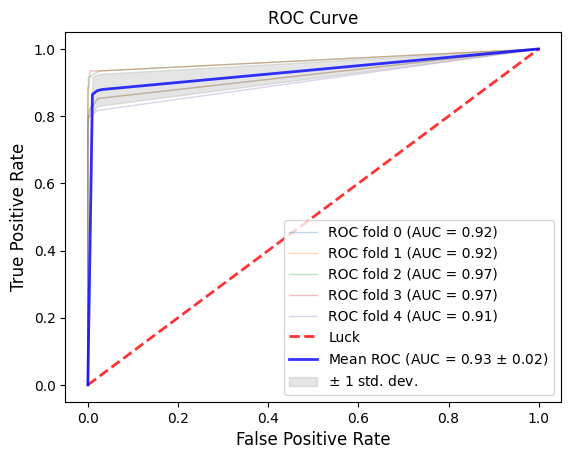

In [ ]:
# criando uma função para plotar o gráfico
def draw_cv_roc_curve(classifier, cv, X, y, title='ROC Curve'):
    # definindo algumas listas vazias para receber o resultado
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # definindo o contador
    i = 0

    # loop ara validação cruzada
    for train, test in cv.split(X, y):

        # executando a função e armazenando as probabilidade dos resultados
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])

        # computando a curva ROC e AUC
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # plotando a curva ROC da validação cruzada em individualmente
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    # plotando a linha diagonal como referência da taxa de 50/50
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # calculando as médias e desvio padrão
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # plotando curva ROC com a média dos resultados
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # customizando o gráfico
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title)
    plt.legend(loc="lower right")

    # exibindo o gráfico
    plt.show()

# executando função e plotando a Curva ROC AUC
draw_cv_roc_curve(best_est, StratifKfold, X_train, y_train, title='ROC Curve')

Pela média dos KFolds, 0.91 nos mostra que o modelo está com uma boa taxa de acertividade.

# 5 - Modelo Final
Após validarmos nosso modelo, utilizaremos todos os dados de X e y, do dataset de treinamento, para o modelo final com os melhores hiperparâmetros encontrados na validação, definir o pipeline e treinar o modelo.

### 5.1 - Treinamento do modelo final
Treinaremos o modelo com os melhores hiperparâmetros encontrados, executaremos o pipeline com o Hídrido e a Random Forest ajustada e por fim, o modelo será treinado.

In [ ]:
# separando novamente os dados
X_all = df_train.drop('Class', axis=1)
y_all = df_train.Class

# instanciando o modelo final com os parametros encontrados na validação cruzada
final_model = rf_grid.best_estimator_

# definindo o pipeline para reamostragem Híbrida e o modelo final
pipeline = Pipeline(steps=[('o', over), ('u', under), ('m', final_model)])

# treinando o modelo com os parametros ajustados com todos os dados
model = pipeline.fit(X_all, y_all)

### 5.2 - Preparação, previsão e avaliação nos dados de teste
Agora é o momento de utilizar aquele conjunto de dados de teste, que dividimos após a Análise Exploratória, com 20% do total dos dados e importante ressaltar que não tocamos em momento algum durante a validação.

Da mesma forma, vamos separar os dados e simular entrada de dados novos para saber se o nosso modelo generaliza bem, o esperado é um resultado um pouco abaixo do que foi validado, mas não muito, pois se ficar abaixo do esperado, devemos re-ajustar o modelo porque resultou em overfitting.

In [ ]:
# separando os dados de teste
X_test = df_test.drop('Class', axis=1)
y_test = df_test.Class

# realizando as predições nos dados de teste
y_pred_test = model.predict(X_test)

# imprimindo os resultados
print(f"accuracy:  {accuracy_score(y_test, y_pred_test)}")
print(f"precision: {precision_score(y_test, y_pred_test)}")
print(f"recall:    {recall_score(y_test, y_pred_test)}")
print(f"f1:        {f1_score(y_test, y_pred_test)}")

accuracy:  0.9996819844172364
precision: 0.9054054054054054
recall:    0.8589743589743589
f1:        0.881578947368421


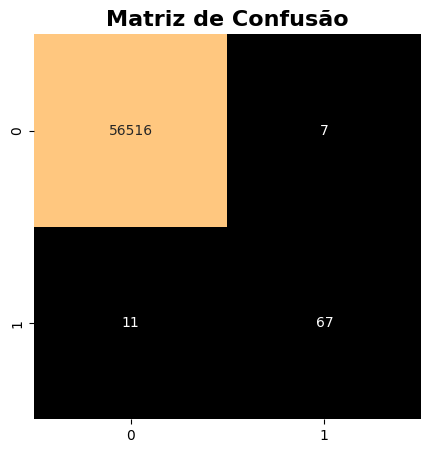

In [ ]:
# Criando matriz de confusão
plt.figure(figsize=(5,5))

sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap=plt.cm.copper, fmt='g', cbar=False)
plt.title("Matriz de Confusão", fontsize=16, fontweight='bold')
plt.show()

Comparando com a Validação Final nos dados de validação, **o resultado nos dados de teste ficaram ótimos.** Nos dados de teste a precisão diminuiu bem pouco, sendo que o recall e o f1-Score aumentaram, podemos comparar abaixo:

In [ ]:
pd.DataFrame(index=['Baseline', 'Validação', 'Teste'],
             data = {"accuracy": [accuracy_score(y_val, y_pred_base_val), np.mean(accuracy_lst), accuracy_score(y_test, y_pred_test)],
                     "precision": [precision_score(y_val, y_pred_base_val), np.mean(precision_lst), precision_score(y_test, y_pred_test)],
                     "recall": [recall_score(y_val, y_pred_base_val), np.mean(recall_lst), recall_score(y_test, y_pred_test)],
                     "f1": [f1_score(y_val, y_pred_base_val), np.mean(f1_lst), f1_score(y_test, y_pred_test)]}
            )

,accuracy,precision,recall,f1
Baseline,0.998940,0.775510,0.506667,0.612903
Validação,0.999409,0.865496,0.772896,0.813801
Teste,0.999682,0.905405,0.858974,0.881579


### 5.3 - Salvando o modelo final treinado

In [ ]:
# Cria o diretório se ele não existir
if not os.path.exists("modelo_final"):
    os.makedirs("modelo_final")

# Salvando o modelo treinado no diretório atual
pkl_filename_model = "modelo_final/RandomForestModel.pkl"
with open(pkl_filename_model, 'wb') as file:
    pickle.dump(model, file)

# # importando o modelo treinado
# with open(pkl_filename_model, 'rb') as file:
#     pickle_RandomForestModel = pickle.load(file)

### 5.4 - Salvando os resultados

In [ ]:
# armazenando as previsões no dataframe de teste
df_test['Predicted'] = y_pred_test

# comparando o real com o previsto no dataframe
df_test['Correct?'] = np.where(df_test['Class'] == df_test['Predicted'], 'Yes', 'No')

# criando uma instancia xlswriter
writer = pd.ExcelWriter('/content/modelo_final/Resultado_final.xlsx', engine='xlsxwriter')

# convertendo o dataframe em um objeto excel
df_test.to_excel(writer, sheet_name='Previsões', index=False)

# salvando o arquivo no diretório atual
writer.save()

## 6 - Conclusão

Ao finalizar nosso modelo, podemos afirmar com confiança que alcançamos um sistema sólido e eficaz para identificar transações fraudulentas em meio a um grande volume de dados. Este pipeline meticulosamente desenvolvido, desde a análise exploratória até a otimização do modelo, resultou em um conjunto de ferramentas capaz de abordar os desafios inerentes a um ambiente de detecção de fraudes em constante evolução.

Por meio do balanceamento das classes com técnicas de amostragem estratégicas, nossa abordagem garantiu que o modelo pudesse detectar transações fraudulentas sem perder a capacidade de distinguir adequadamente as transações genuínas. Isso proporcionou uma base sólida para a construção de um modelo equilibrado e eficaz, capaz de se adaptar às nuances dos dados reais.

A escolha do algoritmo Random Forest como nosso modelo de aprendizado de máquina demonstrou ser acertada, com resultados consistentemente impressionantes nas métricas de avaliação.

A avaliação das curvas ROC-AUC forneceu uma compreensão visual de como nosso modelo opera em diferentes limites de classificação. Através dessa curva, pudemos visualizar a troca entre a taxa de verdadeiros positivos e a taxa de falsos positivos, garantindo que nosso modelo mantivesse um desempenho sólido em todas as áreas relevantes.

Ao implementar uma abordagem de validação cruzada, reforçamos a confiabilidade dos resultados, garantindo que as métricas sejam robustas e representativas da capacidade geral do modelo. Esta prática rigorosa ajudou a mitigar o risco de overfitting e validou a eficácia do modelo em situações do mundo real.

Em conclusão, nosso modelo de detecção de fraude de cartão de crédito não é apenas uma conquista técnica, mas também uma afirmação do compromisso em fornecer um ambiente seguro e confiável para nossos clientes. Através da combinação de técnicas avançadas de amostragem, algoritmos de aprendizado de máquina bem escolhidos e avaliações criteriosas.

## 7 - Recomendações

Depois de finalizado nosso modelo agora ele está pronto para ser colocado em produção

Monitoramento Contínuo: Agora que temos um modelo robusto em vigor, é recomendável implementar um sistema de monitoramento constante. Isso ajudará a identificar possíveis desvios no comportamento das transações ao longo do tempo, permitindo que permaneçamos à frente de novos padrões de fraude.

Classificação de Transações: Ao usar o modelo em um ambiente de produção, podemos aplicá-lo para classificar automaticamente as transações como genuínas ou fraudulentas. Isso permitirá uma análise rápida e precisa, economizando tempo e recursos preciosos.

Integração com Sistemas: Podemos Considar a integração do modelo em sistemas existentes, como plataformas de processamento de transações ou ferramentas de monitoramento. Isso permitirá que os resultados do modelo sejam usados em tempo real, facilitando a tomada de decisões.

